# Image Classification for Rock Paper Scissors Moves

Author: Madison Morgan, 2020

Here is a notebook that demos two different types of deep learning image classifiers.
For Rock Paper Scissors Moves to be used in an app. Here is demonstrated and tested:
    A developed CNN model and a MobileVNET model.
    
Credits: I referenced a few notebooks, tutorials, and data 
* https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_mobilenet_v2/rock_paper_scissors_mobilenet_v2.ipynb#scrollTo=DJ8jGFnTLt8t
* https://www.tensorflow.org/tutorials/images/data_augmentation

Data:
* http://laurencemoroney.com/rock-paper-scissors-dataset

# Table of Contents

* 1.0 [Importing Packages and Defining Constants](#1.0)
* 2.0 [Data Preprocessing](#2.0)
    * 2.1 [Data Preprocessing: CNN Model](#2.1)
    * 2.2 [Defining Data Generators](#2.2)
* 3.0 [Defining the Models](#3.0)
    * 3.1[Defining the Models: CNN Model](#3.1)
    * 3.2[Defining the Models: MobileNetV2](#3.2)
* 4.0 [Training the Models](#4.0)
    * 4.1[Training the Models: CNN Model](#4.1)
    * 4.2[Training the Models: MobileNetV2](#4.2)
* 5.0 [Evaluating Accuracy and Loss of Model](#5.0)
    * 5.1 [Comparing MobileNetV2 Training](#5.1)
* 6.0 [Testing the Model](#6.0)
* 7.0 [Saving Model as TF.Lite for App](#7.0)

# Importing Packages and Defining Constants <a class="anchor" id="1.0"></a>

In [14]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import shutil
import tensorflow as tf
%matplotlib inline

In [2]:
#Define some constants
DATA_PATH ="C://Users//haide//Desktop//MadyProjectz//RPS//Shoot//downloaded//"
TRAIN_PATH = "C://Users//haide//Desktop//MadyProjectz//RPS//Shoot//data//train//"
TEST_PATH = "C://Users//haide//Desktop//MadyProjectz//RPS//Shoot//data//test//"
VALIDATION_PATH = "C://Users//haide//Desktop//MadyProjectz//RPS//Shoot//data//validation//"
BEST_MODEL_PATH_CNN = "best_model_cnn.h5"
BEST_MODEL_PATH_MBNET = "best_model_mbnet.h5"
INPUT_SHAPE = (128,128,3)
TARGET_SIZE = (128,128)
BATCH_SIZE = 32
CLASS_MODE = 'categorical'
TF_DATASET = 'rock_paper_scissors'
TRAINING_SIZE = 0.9 #train CNN with 90% of images
TESTING_SIZE = 0.05 #test CNN with 5% of images
VALIDATION_SIZE = 0.05 #validate CNN with 5% of images

# Data Preprocessing <a class="anchor" id="2.0"></a>
Importing the data and seeing what the heck it looks like

## Data Preprocessing: CNN Model <a class="anchor" id="2.1"></a>
Need only run once, hence commented out to avoid accidentally rerunning, essentially sorted the nescessary files into the proper directories

In [ ]:
#print(len(os.listdir(DATA_PATH+"/paper")))
#print(len(os.listdir(DATA_PATH+"/rock")))
#print(len(os.listdir(DATA_PATH+"/scissors")))

#def moveFiles(files,src,dest):
 #   for file in files:
  #      full_file_name = os.path.join(src, file)
   #     if os.path.isfile(full_file_name):
    #        shutil.copy(full_file_name,dest)


#def separateData():
 #   for move in ['paper','rock','scissors']:
  #      files = os.listdir(DATA_PATH+move)
   #     train_index = math.ceil(len(files)*0.9)
    #    test_index = train_index+ math.ceil(len(files)*0.05)
     #   validation_index = test_index+ math.floor(len(files)*0.05)
    
      #  moveFiles(files[:train_index],DATA_PATH+move,TRAIN_PATH+move)
       # moveFiles(files[train_index:test_index],DATA_PATH+move,TEST_PATH+move)
        #moveFiles(files[test_index:validation_index],DATA_PATH+move,VALIDATION_PATH+move)
    

## Defining Data Generators <a class="anchor" id="2.2"></a>

In [3]:
data_generator = ImageDataGenerator(rescale=1. / 255, rotation_range=90, width_shift_range=0.2,
                            height_shift_range=0.2, horizontal_flip=True, vertical_flip=True, brightness_range=[0.2,1.0], shear_range=0.2, zoom_range=[0.5,1.0], fill_mode='nearest')

validation_generator = ImageDataGenerator(rescale=1./255)

train_generator = data_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=True
)


test_generator = data_generator.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    batch_size=1,
    class_mode=CLASS_MODE
)

validation_generator = validation_generator.flow_from_directory(
    VALIDATION_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE
)

Found 4490 images belonging to 3 classes.
Found 483 images belonging to 3 classes.
Found 107 images belonging to 3 classes.


In [ ]:
#Important to note the labels are diff order
#label_cnn = {[1,0,0]: 'paper', [0,1,0]:'rock', [0,0,1]:'scissors'}
x,y = train_generator.next()
plt.imshow(x[0])
plt.title("Label: "+str(y[0]))
plt.show()


# Defining the Model <a class="anchor" id="3.0"></a>

## Defining the Model: CNN Model <a class="anchor" id="3.1"></a>

In [19]:
class CNN(tf.keras.Model):
    def __init__(self, dataPath, inputShape):
        super(CNN,self).__init__()
        self.datapath = dataPath
        self.model = self.build_model(inputShape)
        self.model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])
        self.model.summary()
        
    
    def build_model(self, inputShape):
        input_model = Input(shape=(inputShape))
        model = Sequential()
        model.add(Conv2D(64, (3, 3), input_shape=inputShape, activation='relu'))
        #model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        #model.add(Dropout(0.2))

        model.add(Conv2D(128, (3, 3), activation='relu'))
        #model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        #model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(3, activation='softmax'))
        
        model.summary()
        output_model=model(input_model)
        model = Model(input_model,output_model)
        return model

In [20]:
CNN = CNN(DATA_PATH, INPUT_SHAPE)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 128)      

In [21]:
checkpoint_callback = ModelCheckpoint(
    BEST_MODEL_PATH_CNN, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_callback  = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 3,
    factor = 0.5,
    min_lr = 0.00001,
    verbose = 1
)

callbacks_list = [checkpoint_callback, reduce_callback]

## Defining the Model: MobileNetV2 for Feature Extraction <a class="anchor" id="3.2"></a>

In [38]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_SHAPE,
  include_top=False,
  weights='imagenet',
  pooling='avg'
)

# Freezing base model, dont want to retrain only want feature extraction!
base_model.trainable= False
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_9[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [39]:
tf.keras.utils.plot_model(
base_model,
show_shapes=True,
show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Adding a Classification Head

In [40]:
model = tf.keras.models.Sequential()

model.add(base_model)

# model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=3, #NUM_CLASSES,
    activation=tf.keras.activations.softmax,
    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
))

model.summary()
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Compiling the Model

In [44]:
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(
    optimizer=rmsprop_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

# Training the Model <a class="anchor" id="4.0"></a>

In [42]:
step_size_train = train_generator.n//train_generator.batch_size
step_size_val = validation_generator.n//validation_generator.batch_size

## Training the Model : CNN Model <a class="anchor" id="4.1"></a>

In [22]:
CNN.history = CNN.model.fit(x=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=25,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   verbose=1,
                   shuffle=True,
                   callbacks=callbacks_list)

Epoch 1/25
140/140 [==============================] - ETA: 0s - loss: 1.2296 - accuracy: 0.3595
Epoch 00001: val_accuracy improved from -inf to 0.58333, saving model to best_model_cnn.h5
140/140 [==============================] - 152s 1s/step - loss: 1.2289 - accuracy: 0.3595 - val_loss: 1.0831 - val_accuracy: 0.5833
Epoch 2/25
140/140 [==============================] - ETA: 0s - loss: 1.0845 - accuracy: 0.3986
Epoch 00002: val_accuracy improved from 0.58333 to 0.71875, saving model to best_model_cnn.h5
140/140 [==============================] - 144s 1s/step - loss: 1.0844 - accuracy: 0.3988 - val_loss: 0.8920 - val_accuracy: 0.7188
Epoch 3/25
140/140 [==============================] - ETA: 0s - loss: 1.0313 - accuracy: 0.4838
Epoch 00003: val_accuracy did not improve from 0.71875
140/140 [==============================] - 145s 1s/step - loss: 1.0312 - accuracy: 0.4839 - val_loss: 0.8836 - val_accuracy: 0.7083
Epoch 4/25
140/140 [==============================] - ETA: 0s - loss: 0.9639

## Training the Model : MobileNetV2 <a class="anchor" id="4.2"></a>

In [45]:
training_history = model.fit(x= train_generator,
    steps_per_epoch = step_size_train,
    epochs=25, 
    validation_data=validation_generator,
    validation_steps = step_size_val,
    verbose =1,
    shuffle=True,
    callbacks=callbacks_list)



Epoch 1/25
140/140 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.5827
Epoch 00001: val_accuracy did not improve from 0.97917
140/140 [==============================] - 63s 435ms/step - loss: 1.0708 - accuracy: 0.5834 - val_loss: 0.2520 - val_accuracy: 0.9688
Epoch 2/25
140/140 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.8005
Epoch 00002: val_accuracy did not improve from 0.97917
140/140 [==============================] - 64s 459ms/step - loss: 0.5544 - accuracy: 0.8007 - val_loss: 0.2239 - val_accuracy: 0.9479
Epoch 3/25
140/140 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8325
Epoch 00003: val_accuracy did not improve from 0.97917
140/140 [==============================] - 61s 434ms/step - loss: 0.4685 - accuracy: 0.8327 - val_loss: 0.1825 - val_accuracy: 0.9688
Epoch 4/25
140/140 [==============================] - ETA: 0s - loss: 0.4336 - accuracy: 0.8537
Epoch 00004: val_accuracy did not improve from 0.

### Fine-Tuning the Training
Here we try to unfreeze some of the top layers of 
the base_model to train it a little bit more so to adjust top layers to our Rock-Paper-Scissors dataset.

In [50]:
# Un-freeze the top layers of the model
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [51]:
# Fine tune from this layer onwards.
fine_tune_at = 149

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# Compile the model using a much-lower training rate.
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(
    optimizer = rmsprop_optimizer,
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()



# The number of additional epochs during which we're going to fine tune the model.
fine_tuning_epochs = 10



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 723,843
Non-trainable params: 1,537,984
_________________________________________________________________


In [52]:
training_history_fine = model.fit(
    x= train_generator,
    steps_per_epoch = step_size_train,
    epochs=25+fine_tuning_epochs, 
    validation_data=validation_generator,
    validation_steps = step_size_val,
    verbose =1,
    shuffle=True,
    callbacks=callbacks_list)
    
    #initial_epoch=initial_epochs,

Epoch 1/35
140/140 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8820
Epoch 00001: val_accuracy did not improve from 0.97917
140/140 [==============================] - 89s 583ms/step - loss: 0.3506 - accuracy: 0.8820 - val_loss: 0.1510 - val_accuracy: 0.9583
Epoch 2/35
140/140 [==============================] - ETA: 0s - loss: 0.2957 - accuracy: 0.9014
Epoch 00002: val_accuracy did not improve from 0.97917
140/140 [==============================] - 77s 547ms/step - loss: 0.2955 - accuracy: 0.9015 - val_loss: 0.2524 - val_accuracy: 0.9271
Epoch 3/35
140/140 [==============================] - ETA: 0s - loss: 0.2565 - accuracy: 0.9241
Epoch 00003: val_accuracy did not improve from 0.97917
140/140 [==============================] - 64s 458ms/step - loss: 0.2565 - accuracy: 0.9241 - val_loss: 0.2545 - val_accuracy: 0.9375
Epoch 4/35
140/140 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.9264
Epoch 00004: val_accuracy did not improve from 0.

Epoch 29/35
140/140 [==============================] - ETA: 0s - loss: 0.1589 - accuracy: 0.9561
Epoch 00029: val_accuracy did not improve from 0.97917
140/140 [==============================] - 61s 436ms/step - loss: 0.1590 - accuracy: 0.9561 - val_loss: 0.1000 - val_accuracy: 0.9688
Epoch 30/35
140/140 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9496
Epoch 00030: val_accuracy did not improve from 0.97917
140/140 [==============================] - 61s 435ms/step - loss: 0.1752 - accuracy: 0.9497 - val_loss: 0.0947 - val_accuracy: 0.9792
Epoch 31/35
140/140 [==============================] - ETA: 0s - loss: 0.1592 - accuracy: 0.9552
Epoch 00031: val_accuracy did not improve from 0.97917
140/140 [==============================] - 61s 437ms/step - loss: 0.1592 - accuracy: 0.9553 - val_loss: 0.1037 - val_accuracy: 0.9688
Epoch 32/35
140/140 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9561
Epoch 00032: val_accuracy did not improve fro

# Evaluating Accuracy and Loss of Model <a class="anchor" id="5.0"></a>

In [48]:
def evaluate_loss_accuracy(history):
    #show the keys contained in history
    #print(history.keys())
    
    #get the accuracy and loss values for training and validation data
    accuracy = history['accuracy']
    validation_accuracy = history['val_accuracy']
    loss = history['loss']
    validation_loss = history['val_loss']
    
    num_epochs = range(len(accuracy))
    plt.plot(num_epochs, accuracy, 'r', label='Training Accuracy')
    plt.plot(num_epochs, validation_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    
    plt.plot(num_epochs, loss, 'r', label='Training Loss')
    plt.plot(num_epochs, validation_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

In [ ]:
#check the training & validation, loss and accuracy of the CNN model
evaluate_loss_accuracy(CNN.history.history)

In [49]:
#check the training & validation, loss and accuracy of the CNN model
evaluate_loss_accuracy(training_history)

TypeError: 'History' object is not subscriptable

## Comparing MobileNetV2 Training<a class="anchor" id="5.1"></a>

In [ ]:
loss = training_history.history['loss'] + training_history_fine.history['loss']
val_loss = training_history.history['val_loss'] + training_history_fine.history['val_loss']

accuracy = training_history.history['accuracy'] + training_history_fine.history['accuracy']
val_accuracy = training_history.history['val_accuracy'] + training_history_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.plot(
[initial_epochs, initial_epochs], 
plt.ylim(),
label='Start Fine Tuning',
linestyle='--'
)
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

In [ ]:
# %%capture
train_loss, train_accuracy = model.evaluate(
    x=dataset_train.batch(BATCH_SIZE).take(NUM_TRAIN_EXAMPLES)
)

test_loss, test_accuracy = model.evaluate(
    x=dataset_test.batch(BATCH_SIZE).take(NUM_TEST_EXAMPLES)
)

print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)
print('\n')
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

# Testing the Model <a class="anchor" id="6.0"></a>

In [53]:
CNN.model.load_weights(BEST_MODEL_PATH_CNN)

In [54]:
testing_model = CNN.model.evaluate(
    test_generator,
    verbose=1
)

483/483 [==============================] - 7s 15ms/step - loss: 0.5332 - accuracy: 0.8240


In [55]:
classes = CNN.model.predict(test_generator, test_generator.n)

In [34]:
print(classes)

[[9.9459732e-01 9.9311670e-05 5.3032562e-03]
 [8.5038356e-02 5.2565938e-01 3.8930231e-01]
 [4.8132735e-01 3.6978346e-01 1.4888917e-01]
 ...
 [2.6699146e-02 9.4913149e-01 2.4169452e-02]
 [2.1073852e-01 2.3584032e-01 5.5342114e-01]
 [9.9928087e-01 6.3140341e-08 7.1904517e-04]]


In [35]:
len(classes)

483

In [36]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
len(test_generator.classes)

Using TensorFlow backend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AttributeError: 'Functional' object has no attribute 'predict_classes'

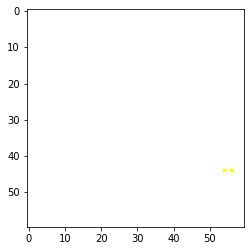

In [37]:
from keras.preprocessing import image
from PIL import Image
import cv2
path = "C://Users//haide//Desktop//MadyProjectz//RPS//Shoot//data///testNEWPHOTOS//"
for file in os.listdir(path):
    img = Image.open(path+file)#, target_size(60,60))
    #print(img.mode)
    img.load()
    background = Image.new("RGB", img.size, (255,255,255))
    background.paste(img,mask=img.split()[3])
    img = background
    img = img.resize((60,60)) 
    img = image.img_to_array(img)
    #print(img.shape)
    imgplot = plt.imshow(img)
    img = img.reshape((1,)+img.shape)
    #print(img.shape)
    
    
    img_class = CNN.model.predict_classes(img)
    print("File: "+str(file)+", pred: "+str(img_class))

In [ ]:
print(img_class)

# Saving Model as TF.Lite for App <a class="anchor" id="7.0"></a>

In [ ]:
model = tf.keras.models.load_model("best_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)